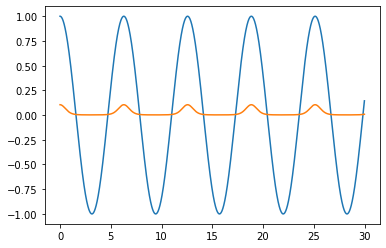

In [33]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.RandomState(42)

def sech(x):
    return 1/np.cosh(x)


def tanh(x):
    return np.tanh(x)


# New touch function
def peak_touch(x, p=[15.,10000., 0.5]):
    y = p[2]*(np.tanh(-x)+1)
    return p[0]/(1 + p[1]*y**2)

def dPeak_dx(x, p=[15.,10000., 0.5]):
    return ((1-tanh(x))*p[0]*p[1]*p[2]*(sech(x))**2)/(1+p[1]*p[2]**2*(1-tanh(x))**2)**2



time = np.arange(0, 30, 0.01)
coseno = 1*np.cos(time)
peak = peak_touch(coseno)
plt.plot(time, coseno)
plt.plot(time, peak)


# Generative Process
$$
  \dot{\vec{x}}(t) = f(\vec{x}(t), \alpha(t)) =
      \left[\begin{array}{ccc} 0 & 1 & 0 \\ -\omega^2 & 0 & 0 \\ \alpha(t) &0 &-1 \end{array}\right] \cdot \vec{x}(t) =
      \left[\begin{array}{c} x_1(t) \\ -\omega^2 x_0(t) \\ \alpha(t) x_0(t) - x_2(t) \end{array}\right] \nonumber
$$
## Initial conditions
$$
\vec{x}(0) = \left[ \begin{array}{c} x_0(0) \\ x_1(0) \\ x_2(0) \end{array} \right] = \left[ \begin{array}{c} 1 \\ 0 \\ \frac{ \alpha(0) }{ \omega^2 +1 } \end{array} \right]
$$
## Solution
$$
\vec{x}(t) =
  \left[ \begin{array}{c} x_0(t) \\ x_1(t) \\ x_2(t) \end{array} \right] =
  \left[ \begin{array}{c} \cos(\omega t) \\ - \omega \sin(\omega t) \\ \frac{ \alpha ( \cos (\omega t) + \omega \sin (\omega t) ) }{ \omega^2 + 1 } \end{array} \right]
$$
$$
\frac{\partial s_1}{\partial \alpha} = \frac{\partial s_1}{\partial \mu_2}\frac{\partial \mu_2}{\partial \alpha} + \frac{\partial s_1}{\partial \dot{\mu}_2}\frac{\partial \dot{\mu}_2}{\partial \alpha}
$$

From $x_2$ is extracted the proprioceptive sensory input
$$
s_0 (t) = x_2(t) + \mathcal{N}(s_0;0,\Sigma_{s_0}^{GP})
$$
and the following function of angle and platform position (in whisker angle space) is given the touch sensory input
$$
s_1 (t) = \frac{ 1 }{ 2 } \text{tanh}(100(x_2-x_{platform}) + 1)
$$


In [34]:

# Generative Process Class
class GP:

    def __init__(self, dt, omega2_GP=0.5, alpha=1):

        # Harmonic oscillator angular frequency (both x_0 and x_2)
        self.omega2 = omega2_GP
        # Harmonic oscillator amplitude (no really)
        self.a = alpha
        # Vector x={x_0, x_1, x_2} initialized with his initial conditions
        self.x = np.array([1., 0.,1/1.5])
        # Array storing respectively proprioceptive sensory input (initialized with the real value x_2) and touch sensory input
        self.s = np.array([self.a/(self.omega2 + 1), 0.])
        # Variance of the Gaussian noise that gives proprioceptive sensory input
        self.Sigma_s = 0.01
        # Size of a simulation step
        self.dt = dt
        # Time variable
        self.t = 0
        # Platform position (when is present) with respect to x_2 variable
        self.platform_position = 0.5
        # Time interval in which the platform appears
        self.platform_interval = [25, 100]

    def touch(self, x, platform_position, prec=500):
        return 0.5 * tanh(prec*(x-platform_position)) + 0.5

    # Function that implement dynamics of the process.
    def update(self, action):
        # Action argument (double) is the variable that comes from the GM that modifies alpha
        # variable affecting the amplitude of the oscillation.

        # Increment of time variable
        self.t += self.dt
        # Increment of alpha variable (that changes the amplitude) given by agent's action
        self.a += action
        # GP dynamics implementation
        self.x[0] += self.dt*(self.x[1])
        self.x[1] += self.dt*(-self.omega2*self.x[0])
        self.x[2] += self.dt*(self.a*self.x[0] - self.x[2])
        # Platform Action
        if self.t > self.platform_interval[0] and self.t < self.platform_interval[1]:
            self.s[1] = self.touch(self.x[2], self.platform_position)
            if self.x[2]>self.platform_position:
                self.x[2] = self.platform_position
        else:
            self.s[1] = 0.
        self.s[0] = self.x[2] + self.Sigma_s*rng.randn()

    def platform_for_graph(self):
        plat = []
        for t in np.arange(0., self.t, self.dt):
            if t in self.platform_interval:
                plat.append([t, self.platform_position])
        return np.vstack(plat)


# Generative Model
## Agent beliefs
$$
\dot{\vec{\mu}}(t) = f_{dyn}(\vec{\mu}(t), \nu) + z_{\vec{\mu}}=
      \left[\begin{array}{ccc} 0 & 1 & 0 \\ -\omega^2 & 0 & 0 \\ \nu & 0 & -1 \end{array} \right] \cdot \vec{\mu}(t) + \mathcal{N}(\dot{\vec{\mu}}; 0, \hat{\Sigma}_{\vec{\mu}})
$$
with $\hat{\Sigma}_{\vec{\mu}}$ covariance matrix of the multidimensional gaussian noise. In our case it is a diagonal matrix with diagonal $\Sigma_{\mu_0}, \Sigma_{\mu_1}, \Sigma_{\mu_2}$
$$
s_p(\vec{\mu}(t), \nu) =
      \left[\begin{array}{c} 0 \\ 0 \\ 1 \end{array} \right]^T \cdot \vec{\mu}(t) + \mathcal{N}(s_p; 0, \Sigma_{s_0})
$$
$$
s_t(\mu_2(t), \dot{\mu}_2(t)) = g(\mu_2(t), \dot{\mu}_2(t)) + \mathcal{N}(s_t; 0, \Sigma_{s_1}) = g_1(\dot{\mu}_2) g_2(\mu_2) + \mathcal{N}(s_t; 0, \Sigma_{s_1})
$$
with
$$
g_1(\dot{\mu}_2) = \text{sech}(10 \dot{\mu}_2) = \frac{ 2 }{ e^{10 \dot{\mu}_2} + e^{-10 \dot{\mu}_2} } \\
g_2(\mu_2) = \frac{ 1 }{ 2 } (\text{tanh}(10 \mu_2) + 1)
$$
for later is important to notice that
$$
\frac{ d g }{ d \dot{\mu}_2 } = -10 \text{sech}(10 \dot{\mu}_2) \text{tanh}(10 \dot{\mu}_2) \frac{ 1 }{ 2 } (\text{tanh}(10 \mu_2) + 1)\\
\frac{ d g }{ d \mu_2 } = 5 \text{sech}^2(10 \mu_2) \text{sech}(10 \dot{\mu}_2)
$$
## Free Energy
$$
\begin{align}
F \approx& \frac{1}{2} \left[ \frac{(\dot{\mu_0}-\mu_1)^2}{\Sigma_{\mu_0}}
                      + \frac{(\dot{\mu_1}+ \omega^2 \mu_0)^2}{\Sigma_{\mu_1}}
                      + \frac{(\dot{\mu_2}-(\nu \mu_0 - \mu_2))^2}{\Sigma_{\mu_2}}
                      + \frac{(s_0-\mu_2)^2}{\Sigma_{s_0}}
                      + \frac{(s_1-g(\mu_2, \dot{\mu}_2))^2}{\Sigma_{s_1}} \right] \\
        =& \frac{1}{2} \left[ \frac{\varepsilon_{\mu_0}^2}{\Sigma_{\mu_0}}
                      + \frac{\varepsilon_{\mu_1}^2}{\Sigma_{\mu_1}}
                      + \frac{\varepsilon_{\mu_2}^2}{\Sigma_{\mu_2}}
                      + \frac{\varepsilon_{s_0}^2}{\Sigma_{s_0}}
                      + \frac{\varepsilon_{s_1}^2}{\Sigma_{s_1}} \right]
\end{align}
$$
## Prediction errors
$$
\begin{align}
\varepsilon_{\mu_0} &= \dot{\mu_0}-\mu_1 \\
\varepsilon_{\mu_1} &= \dot{\mu_1}+ \omega^2 \mu_0 \\
\varepsilon_{\mu_2} &= \dot{\mu_2}-(\nu \mu_0 - \mu_2) \\
\varepsilon_{s_0} &= s_0-\mu_2 \\
\varepsilon_{s_1} &= s_1-g(\mu_2, \dot{\mu}_2)
\end{align}
$$
## Gradients
$$
\begin{align}
\frac{ \partial F }{ \partial \mu_0 } &= \omega^2 \frac{ \varepsilon_{\mu_1} }{ \Sigma_{\mu_1} } - \nu \frac{ \varepsilon_{\mu_2} }{ \Sigma_{\mu_2} } \\
\frac{ \partial F }{ \partial \mu_1 } &= -\frac{ \varepsilon_{\mu_0} }{ \Sigma_{\mu_0} } \\
\frac{ \partial F }{ \partial \mu_2 } &= \frac{ \varepsilon_{\mu_2} }{ \Sigma_{\mu_2} } - \frac{ \varepsilon_{s_0} }{ \Sigma_{s_0} } - \frac{ \partial g(\mu_2, \dot{\mu}_2) }{ \partial \mu_2 } \frac{ \varepsilon_{s_1} }{ \Sigma_{s_1} }\\
\frac{ \partial F }{ \partial \dot{\mu}_0 } &= \frac{ \varepsilon_{\mu_0} }{ \Sigma_{\mu_0} }\\
\frac{ \partial F }{ \partial \dot{\mu}_1 } &= \frac{ \varepsilon_{\mu_1} }{ \Sigma_{\mu_1} }\\
\frac{ \partial F }{ \partial \dot{\mu}_2 } &= \frac{ \varepsilon_{\mu_2} }{ \Sigma_{\mu_2} } - \frac{ \partial g(\mu_2, \dot{\mu}_2) }{ \partial \dot{\mu}_2 } \frac{ \varepsilon_{s_1} }{ \Sigma_{s_1} }
\end{align}
$$
## Internal variables dynamics
$$
\left[ \begin{matrix} \mu_0(t+dt) \\ \mu_1(t+dt) \\ \mu_2(t+dt) \end{matrix} \right] =
\left[ \begin{matrix} \mu_0(t) + dt \, (\dot{\mu}_0(t) - \eta \frac{ \partial F }{ \partial \mu_0 }) \\
					  \mu_1(t) + dt \, (\dot{\mu}_1(t) - \eta \frac{ \partial F }{ \partial \mu_1 }) \\
					  \mu_2(t) + dt \, (\dot{\mu}_2(t) - \eta \frac{ \partial F }{ \partial \mu_2 })
\end{matrix} \right]
$$
$$
\left[ \begin{matrix} \dot{\mu}_0(t+dt) \\ \dot{\mu}_1(t+dt) \\ \dot{\mu}_2(t+dt) \end{matrix} \right] =
\left[ \begin{matrix} \dot{\mu}_0(t) - dt \, \eta_d \frac{ \partial F }{ \partial \dot{\mu}_0 } \\
					  \dot{\mu}_1(t) - dt \, \eta_d \frac{ \partial F }{ \partial \dot{\mu}_1 } \\
					  \dot{\mu}_2(t) - dt \, \eta_d \frac{ \partial F }{ \partial \dot{\mu}_2 }
\end{matrix} \right]
$$
with $\eta$ and $\eta_d$ gradient descent parameters respectively of $\vec{\mu}$ and $\dot{\vec{\mu}}$
## Action
the agent modifies a certain variable of the GP (in our case the alpha parameter) by a quantity given by
$$
da = -dt \eta_a \left( \frac{ \partial F }{ \partial s_0 }\frac{ \partial s_0 }{ \partial \alpha  } + \frac{ \partial F }{ \partial s_1 }\frac{ \partial s_1 }{ \partial \alpha  } \right)
      = -dt \eta_a \left( \frac{ \varepsilon_{s_0} }{ \Sigma_{s_0} }\frac{ \partial s_0 }{ \partial \alpha  } + \frac{ \varepsilon_{s_1} }{ \Sigma_{s_1} }\frac{ \partial s_1 }{ \partial \alpha  } \right)
$$
with
$$
\begin{align}
\frac{\partial F}{ \partial s_0 } &= \frac{ \varepsilon_{s_0} }{ \Sigma_{s_0} } \\
\frac{\partial F}{ \partial s_1 } &= \frac{ \varepsilon_{s_1} }{ \Sigma_{s_1} } \\
\frac{ \partial s_0 }{ \partial \alpha } &= \frac{ \cos (\omega t) + \omega \sin (\omega t) }{ \omega^2 + 1 } = \frac{ x_0 - x_1}{ \omega^2 + 1 }  \approx ? \frac{ \mu_0 - \mu_1 }{ \omega^2 + 1 }\\
\frac{ \partial s_1 }{ \partial \alpha } &= ? = -10 \, x_0 \, \text{sech}\left(10 (\alpha x_0 - x_2)\right) \, \text{tanh}\left(10 (\alpha x_0 - x_2)\right) \, \left( \frac{ 1 }{ 2 }\text{tanh}(10 x_2) + \frac{ 1 }{ 2 } \right) \approx ? -10 \, \mu_0 \, \text{sech}\left(10 (\alpha \mu_0 - \mu_2)\right) \, \text{tanh}\left(10 (\alpha \mu_0 - \mu_2)\right) \, \left( \frac{ 1 }{ 2 }\text{tanh}(10 \mu_2) + \frac{ 1 }{ 2 } \right)
\end{align}
$$
## Learning of the $\nu$ parameter
$$
\nu(t+dt) = \nu (t) - dt \eta_{\nu} \frac{ \partial F }{ \partial \nu }
$$
with
$$
\frac{ \partial F }{ \partial \nu } = - \mu_0 \frac{ \varepsilon_{\mu_2} }{ \Sigma_{\mu_2} } - \frac{ \varepsilon_{s_1} }{ \Sigma_{s_1} }\frac{ \partial g(\mu_2, \dot{\mu}_2) }{ \partial \nu  } =
  - \mu_0 \frac{ \varepsilon_{\mu_2} }{ \Sigma_{\mu_2} } - \frac{ \varepsilon_{s_1} }{ \Sigma_{s_1} } \left[ -10 \, \mu_0 \, \text{sech}\left(10 (\nu \mu_0 - \mu_2)\right) \, \text{tanh}\left(10 (\nu \mu_0 - \mu_2)\right) \, \left( \frac{ 1 }{ 2 }\text{tanh}(10 \mu_2) + \frac{ 1 }{ 2 } \right) \right]
$$

In [35]:

#Generative model class
class GM:

    def __init__(self, dt, eta=0.1, eta_d=0.1, eta_a=1, eta_nu=1, omega2_GM=0.5, nu=1):

        # Harmonic oscillator angular frequency
        self.omega2 = omega2_GM
        # Harmonic oscillator amplitude (no really)
        self.nu = nu
        # Vector \vec{\mu}={\mu_0, \mu_1, \mu_2} initialized with the GP initial conditions
        self.mu = np.array([1., 0., self.nu/(self.omega2+1)])
        # Vector \dot{\vec{\mu}}={\dot{\mu_0}, \dot{\mu_1}, \dot{\mu_2}} inizialized with the right ones
        self.dmu = np.array([0., -self.omega2, (self.nu*self.mu[0]-self.mu[2])])
        # Variances (inverse of precisions) of sensory input (the first one proprioceptive and the second one touch)
        self.Sigma_s = np.array([1.1, 0.05])
        # Internal variables precisions
        self.Sigma_mu = np.array([0.008, 0.008, 0.008])
        # Action variable (in this case the action is intended as the increment of the variable that the agent is allowed to modified)
        self.da = 0
        # Size of a simulation step
        self.dt = dt
        # Gradient descent weights
        self.eta = np.array([eta, eta_d, eta_a, eta_nu])

    # Touch function
    def g_touch(self, x, v, prec=50):
        return sech(prec*v)*(0.5*tanh(prec*x)+0.5)

    # Derivative of the touch function with respect to v
    def dg_dv(self, x, v, prec=50):
        return -prec*sech(prec*v)*tanh(prec*v)*(0.5 * tanh(prec*x) + 0.5)

    # Derivative of the touch function with respect to x
    def dg_dx(self, x, v, prec=50):
        return sech(prec*v)*prec*0.5*(sech(prec*x))**2

    # New touch function
    def peak_touch(x, p=[1.,100., 0.5]):
        y = p[2]*(np.tanh(-x)+1)
        return p[0]/(1 + p[1]*y**2)

    def dPeak_dx(x, p=[1.,100., 0.5]):
        return ((1-tanh(x))*p[0]*p[1]*p[2]*(sech(x))**2)/(1+p[1]*p[2]**2*(1-tanh(x))**2)**2


    # Function that implement the update of internal variables.
    def update(self, sensory_states):
        # sensory_states argument (two dimensional array) come from GP and store proprioceptive
        # and somatosensory perception
        # Returns action increment

        self.s = sensory_states
        eta, eta_d, eta_a, eta_nu = (self.eta[0], self.eta[1], self.eta[2], self.eta[3])

        self.PE_mu = np.array([
            self.dmu[0]-self.mu[1],
            self.dmu[1]+self.omega2*self.mu[0],
            self.dmu[2]-(self.nu*self.mu[0]-self.mu[2])
        ])
        self.PE_s = np.array([
            self.s[0]-self.mu[2],
            #self.s[1] - peak_touch(self.mu[2])
            self.s[1]-self.g_touch(x=self.mu[2], v=self.dmu[2])  # v=self.nu*self.mu[0]-self.mu[2] or v=self.dmu[2]?
        ])

        self.dF_dmu = np.array([
            self.omega2*self.PE_mu[1]/self.Sigma_mu[1] - self.nu*self.PE_mu[2]/self.Sigma_mu[2],
            -self.PE_mu[0]/self.Sigma_mu[0],
            self.PE_mu[2]/self.Sigma_mu[2] - self.PE_s[0]/self.Sigma_s[0] \
                - self.dg_dx(x=self.mu[2], v=self.dmu[2])*self.PE_s[1]/self.Sigma_s[1]
        ])

        self.dF_d_dmu = np.array([
            self.PE_mu[0]/self.Sigma_mu[0],
            self.PE_mu[1]/self.Sigma_mu[1],
            self.PE_mu[2]/self.Sigma_mu[2] #- self.dg_dv(x=self.mu[2], v=self.dmu[2])*self.PE_s[1]/self.Sigma_s[1]
        ])

        # Action update
        self.dF_da = np.array([ np.sign(self.mu[2])*self.PE_s[0]/self.Sigma_s[0] , self.PE_s[1]/self.Sigma_s[1] ]) #self.mu[0]*dPeak_dx(self.mu[2])*self.PE_s[1]/self.Sigma_s[1] ])
        #self.dF_da = np.array([ 0*self.PE_s[0]/self.Sigma_s[0] , self.mu[0]*self.dg_dv(x=self.mu[2], v=self.dmu[2])*self.PE_s[1]/self.Sigma_s[1] ]) # + self.mu[2]*self.dg_dx(x=self.mu[0], v=self.dmu[2])*self.PE_s[1]/self.Sigma_s[1] ]) #self.mu[0] * self.PE_s[1]/self.Sigma_s[1] ])
        self.da = -self.dt*eta_a*(self.dF_da[0] + self.dF_da[1])

        # Learning internal parameter nu
        #self.dF_dnu = np.array([-self.mu[0]*self.PE_mu[2]/self.Sigma_mu[2], -self.dg_dv(x=self.mu[0], v=self.dmu[2]) ])
        #self.dF_dnu = np.array([-self.mu[0]*self.PE_mu[2]/self.Sigma_mu[2], -self.mu[0]* self.PE_s[1]/self.Sigma_s[1] ])
        #self.nu += -self.dt*eta_nu* (self.dF_dnu[0] + 0.001*self.dF_dnu[1])

        # Internal variables update
        #self.mu[0] += self.dt*(self.dmu[0] - eta[0]*self.dF_dmu[0])
        #self.mu[1] += self.dt*(self.dmu[1] - eta[1]*self.dF_dmu[1])
        #self.mu[2] += self.dt*(self.dmu[2] - eta[2]*self.dF_dmu[2])
        self.mu += self.dt*(self.dmu - eta*self.dF_dmu)
        self.dmu += -self.dt*eta_d*self.dF_d_dmu

        #dF_da = (self.mu[0])*self.PE_s[0]/self.Sigma_s[0] + ( self.mu[0] ) * self.PE_s[1]/self.Sigma_s[1]
        #self.da = self.dt*eta_a*dF_da


        # Efference copy
        self.nu += -self.dt*eta_a*(self.mu[0]*self.dF_da[1])

        return self.da



In [36]:

if __name__ == "__main__":
    dt = 0.005
    n_steps = 25000
    gp = GP(dt=dt, omega2_GP=0.5, alpha=1)
    gm = GM(dt=dt, eta=0.001, eta_d=2., eta_a=0.03, eta_nu=0.01, omega2_GM=0.5, nu=1)

    data_GP = []
    data_GM = []
    a = 0.
    for step in np.arange(n_steps):
        a = gm.update(gp.s)
        gp.update(a)
        data_GP.append([gp.x[2], gp.a, gp.s[0], gp.s[1], gp.x[0]])
        data_GM.append([gm.mu[2], gm.nu, gm.PE_mu[0], gm.PE_mu[1], gm.PE_mu[2],
                        gm.PE_s[0], gm.PE_s[1], gm.dmu[2], gm.mu[0], gm.dF_da[0], gm.dF_da[1], peak_touch(gm.mu[2]), gm.g_touch(x=gm.mu[2], v=gm.dmu[2]) ])
    data_GP = np.vstack(data_GP)
    data_GM = np.vstack(data_GM)
    platform = gp.platform_for_graph()

    

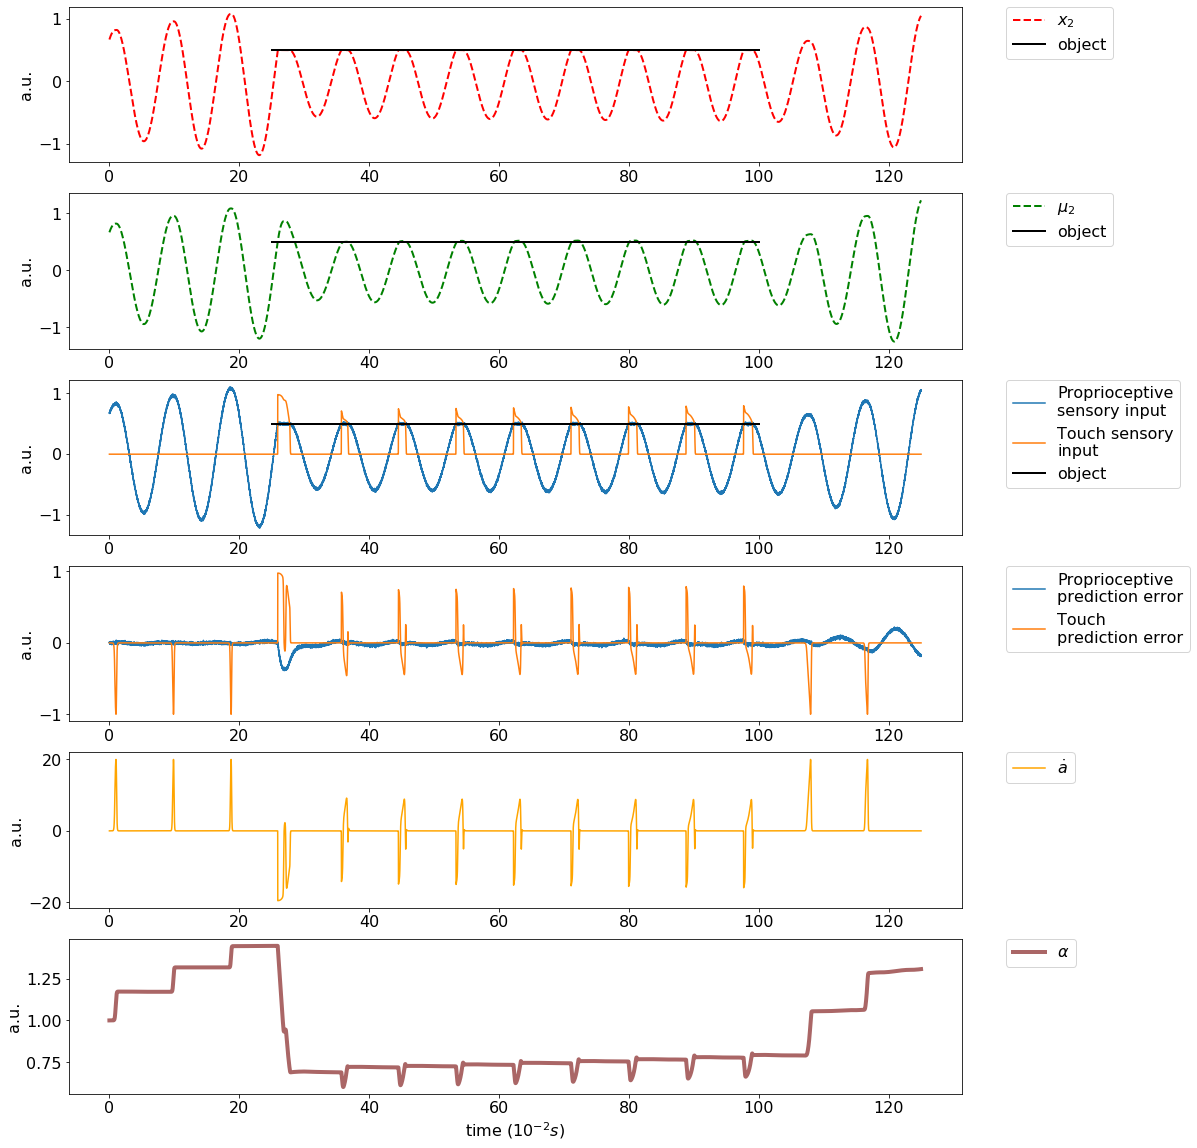

In [62]:
    plt.figure(figsize=(16, 20))
    plt.rcParams['font.size'] = '16'
    plt.subplot(611)
    plt.plot(np.arange(0, n_steps*dt, dt), data_GP[:, 0], c="red", lw=2, ls="dashed", label=r"$x_2$")
    #plt.plot(np.arange(0, n_steps*dt, dt), data_GP[:, 4], c="blue", lw=2, ls="dashed", label=r"$x_0$")
    plt.plot(platform[:,0], platform[:,1], c="black", lw=2, label="object")
    #plt.ylim(bottom=-1.8, top=4)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.ylabel("a.u.")
    plt.subplot(612)
    plt.plot(np.arange(0, n_steps*dt, dt), data_GM[:, 0],
             c="green", lw=2, ls="dashed", label=r"$\mu_2$")
    #plt.plot(np.arange(0, n_steps*dt, dt), data_GM[:, 1], c="#66aa66", lw=3, label=r"\nu")
    #plt.plot(np.arange(0, n_steps*dt, dt), data_GM[:, 8], c="blue", lw=2, ls="dashed", label=r"$\mu_0$")
    plt.plot(platform[:,0], platform[:,1], c="black", lw=2, label="object")
    #plt.ylim(bottom=-1.8, top=4)
    plt.ylabel("a.u.")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.subplot(613)
    plt.plot(np.arange(0, n_steps*dt, dt), data_GP[:, 2], label="Proprioceptive\nsensory input")
    plt.plot(np.arange(0, n_steps*dt, dt), data_GP[:, 3], label="Touch sensory\ninput")
    #plt.plot(platform[:,0], platform[:,1], c="black", lw=0.5, label="platform")
    # plt.ylim(bottom=0)
    plt.plot(platform[:,0], platform[:,1], c="black", lw=2, label="object")
    plt.ylabel("a.u.")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.subplot(614)    
    plt.plot(np.arange(0, n_steps*dt, dt), data_GM[:, 5], label="Proprioceptive\nprediction error")
    plt.plot(np.arange(0, n_steps*dt, dt), data_GM[:, 6], label="Touch\nprediction error")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.ylabel("a.u.")
    plt.subplot(615)
    plt.plot(np.arange(0, n_steps*dt, dt), -gm.eta[2]*data_GM[:, 10], c = "orange", label=r"$\dot{a}$")
    plt.ylabel("a.u.")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.subplot(616)
    plt.plot(np.arange(0, n_steps*dt, dt), data_GP[:, 1], c="#aa6666", lw=4, label=r"$\alpha$")
    plt.xlabel(r"time ($10^{-2}s$)")
    plt.ylabel("a.u.")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig("simulation_results")
    plt.show()

    

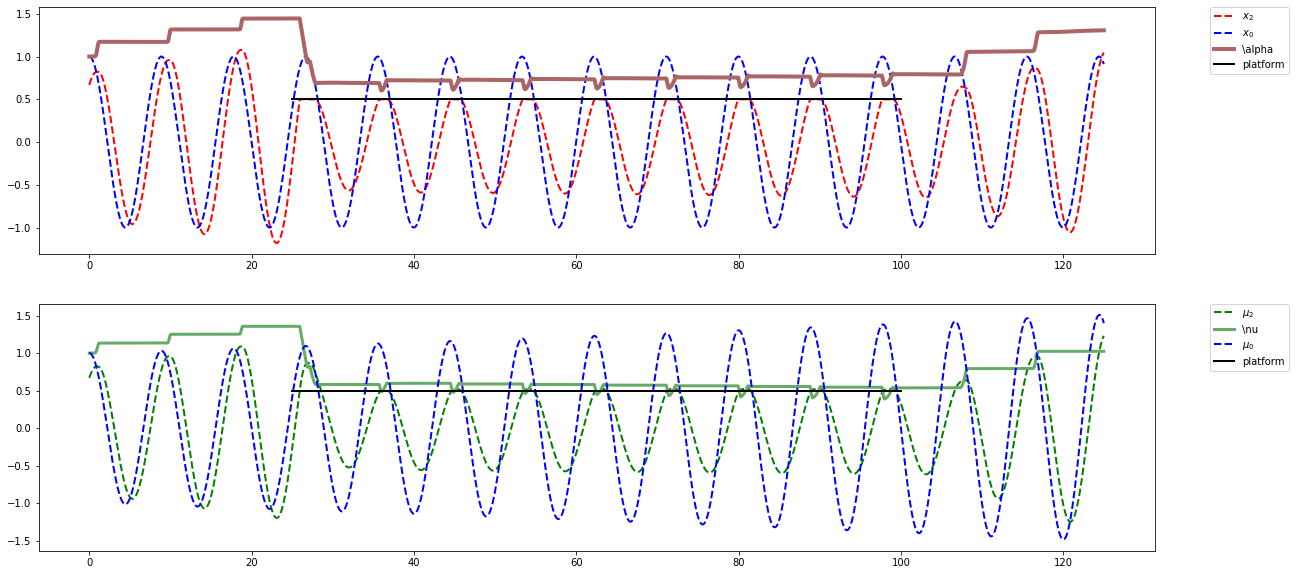

In [38]:
    plt.figure(figsize=(20, 10))
    plt.subplot(211)
    plt.plot(np.arange(0, n_steps*dt, dt), data_GP[:, 0], c="red", lw=2, ls="dashed", label=r"$x_2$")
    plt.plot(np.arange(0, n_steps*dt, dt), data_GP[:, 4], c="blue", lw=2, ls="dashed", label=r"$x_0$")
    plt.plot(np.arange(0, n_steps*dt, dt), data_GP[:, 1], c="#aa6666", lw=4, label=r"\alpha")
    plt.plot(platform[:,0], platform[:,1], c="black", lw=2, label="platform")
    #plt.ylim(bottom=-1.8, top=4)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.subplot(212)
    plt.plot(np.arange(0, n_steps*dt, dt), data_GM[:, 0],
             c="green", lw=2, ls="dashed", label=r"$\mu_2$")
    plt.plot(np.arange(0, n_steps*dt, dt), data_GM[:, 1], c="#66aa66", lw=3, label=r"\nu")
    plt.plot(np.arange(0, n_steps*dt, dt), data_GM[:, 8], c="blue", lw=2, ls="dashed", label=r"$\mu_0$")
    plt.plot(platform[:,0], platform[:,1], c="black", lw=2, label="platform")
    #plt.plot(np.arange(0, n_steps*dt, dt), data_GM[:, 10]*gm.Sigma_s[1], c="orange", label=r"$\, \frac{ d\varepsilon_{s_1} }{ da }$")
    #plt.ylim(bottom=-1.8, top=4)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()



    

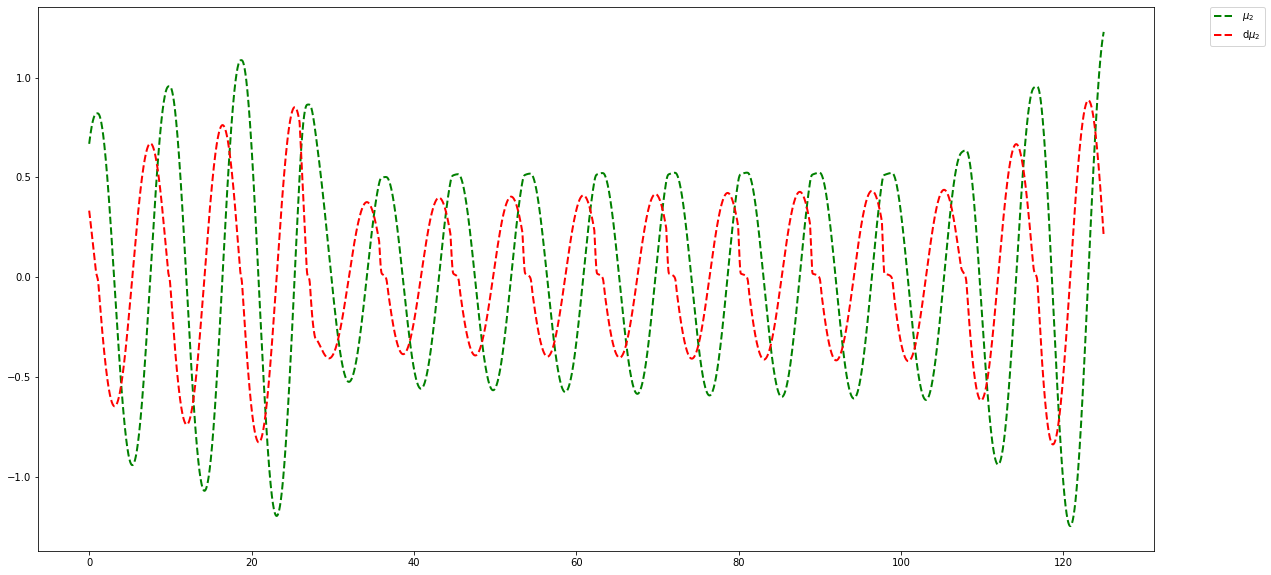

In [39]:

    plt.figure(figsize=(20, 10))
    plt.plot(np.arange(0, n_steps*dt, dt), data_GM[:, 0], c="green", lw=2, ls="dashed", label=r"$\mu_2$")
    plt.plot(np.arange(0, n_steps*dt, dt), data_GM[:, 7], c="red", lw=2, ls="dashed", label=r"d$\mu_2$")
    #plt.plot(np.arange(0, n_steps*dt, dt), data_GM[:, 11], c="purple", lw=2, ls="dashed", label=r"d$\mu_2$")
    #plt.plot(np.arange(0, n_steps*dt, dt), data_GM[:, 12], c="grey", lw=2, ls="dashed", label=r"d$\mu_2$")
    #plt.plot(np.arange(0, n_steps*dt, dt), gm.g_touch(x=data_GM[:, 0], v=data_GM[:, 7]), label=r"touch")
    #plt.plot(np.arange(0, n_steps*dt, dt), data_GM[:, 1], c="#66aa66", lw=3, label=r"\nu")
    #plt.plot(np.arange(0, n_steps*dt, dt), data_GM[:, 8], c="blue", lw=2, ls="dashed", label=r"$\mu_0$")
    #plt.plot(platform[:,0], platform[:,1], c="black", lw=2, label="platform")
    #plt.ylim(bottom=-1.8, top=4)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

    

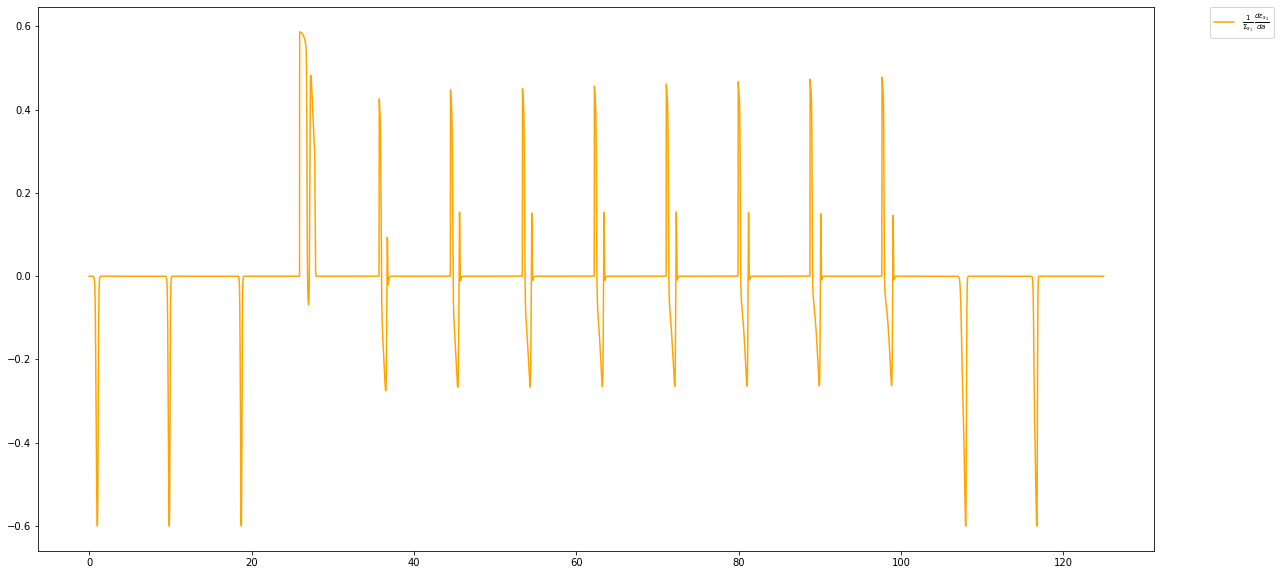

In [40]:
    plt.figure(figsize=(20, 10))
    #plt.plot(np.arange(0, n_steps*dt, dt), data_GM[:, 9], label=r"$\frac{ 1 }{ \Sigma_{s_0} } \, \frac{ d\varepsilon_{s_0} }{ da }$")
    plt.plot(np.arange(0, n_steps*dt, dt), gm.eta[2]*data_GM[:, 10], c = "orange", label=r"$\frac{ 1 }{ \Sigma_{s_1} } \, \frac{ d\varepsilon_{s_1} }{ da }$")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    

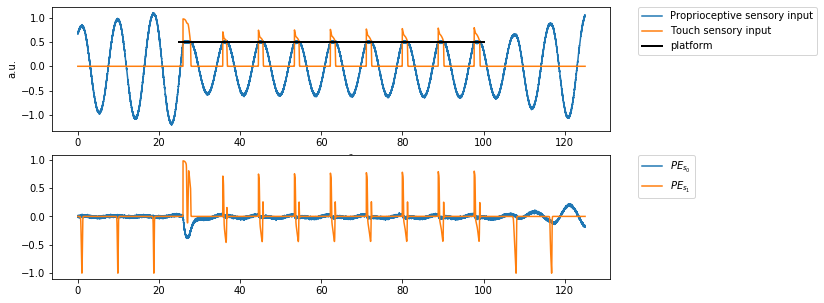

In [48]:
    plt.figure(figsize=(10, 5))
    plt.subplot(211)
    plt.plot(np.arange(0, n_steps*dt, dt), data_GP[:, 2], label="Proprioceptive sensory input")
    plt.plot(np.arange(0, n_steps*dt, dt), data_GP[:, 3], label="Touch sensory input")
    #plt.plot(platform[:,0], platform[:,1], c="black", lw=0.5, label="platform")
    # plt.ylim(bottom=0)
    plt.plot(platform[:,0], platform[:,1], c="black", lw=2, label="platform")
    plt.ylabel("a.u.")
    plt.xlabel(r"time ($10^{-2}s$)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.subplot(212)    
    plt.plot(np.arange(0, n_steps*dt, dt), data_GM[:, 5], label=r"$PE_{s_0}$")
    plt.plot(np.arange(0, n_steps*dt, dt), data_GM[:, 6], label=r"$PE_{s_1}$")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig("sensory_inputs")
    plt.show()

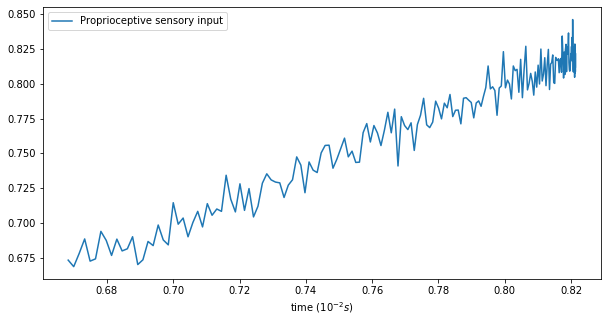

In [42]:

    plt.figure(figsize=(10, 5))
    plt.plot(data_GM[:200, 0], data_GP[:200, 2], label="Proprioceptive sensory input")
    plt.xlabel(r"time ($10^{-2}s$)")
    plt.legend()
    plt.show()

    

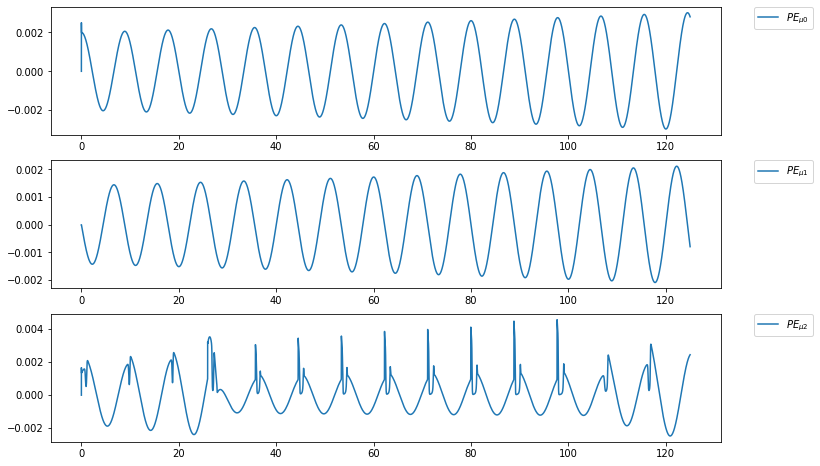

In [43]:
    plt.figure(figsize=(12, 8))
    plt.subplot(311)
    plt.plot(np.arange(0, n_steps*dt, dt), data_GM[:, 2], label=r"$PE_{\mu 0}$")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.subplot(312)
    plt.plot(np.arange(0, n_steps*dt, dt), data_GM[:, 3], label=r"$PE_{\mu 1}$")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.subplot(313)
    plt.plot(np.arange(0, n_steps*dt, dt), data_GM[:, 4], label=r"$PE_{\mu 2}$")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()
    

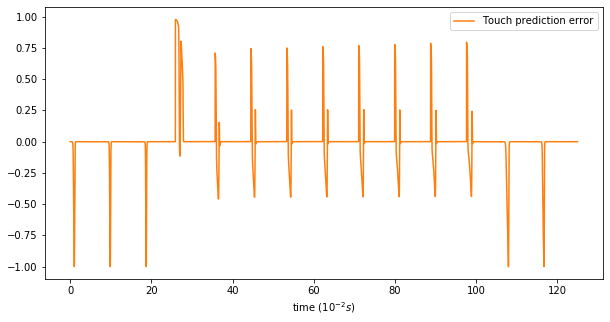

In [44]:
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(0, n_steps*dt, dt), data_GM[:, 6], label="Touch prediction error", c='#ff7f0e')
    plt.xlabel(r"time ($10^{-2}s$)")
    plt.legend()
    #plt.savefig("touch_PE")
    plt.show()
    

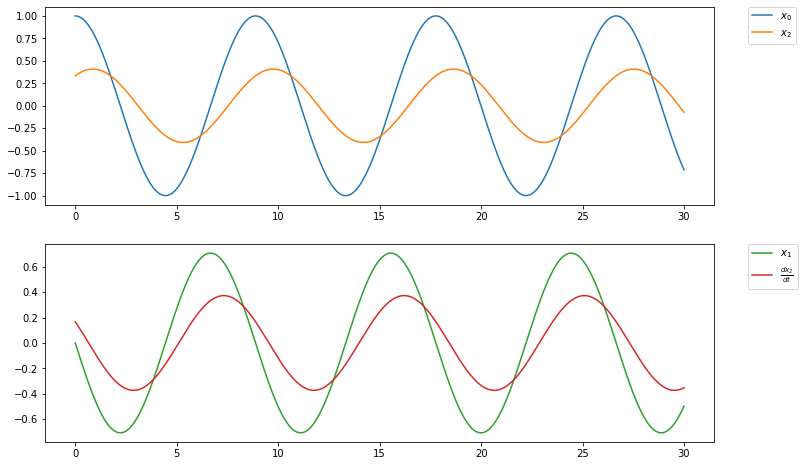

In [45]:
    gm = GM(dt=0.005)
    omega = np.sqrt(gm.omega2)
    nu = 0.5 # gm.nu
    time = np.arange(0, 30, 0.001)
    x0 = np.cos(omega*time)
    x1 = -omega*np.sin(omega*time)
    x2 = nu*(np.cos(omega*time)+omega*np.sin(omega*time))/(omega**2+1)
    dx2 = nu*(-np.sin(omega*time)+omega**2*np.cos(omega*time))/(omega**2+1)
    touch = gm.g_touch(x=x2, v=dx2)
    #dtouch_dx0 = gm.dg_dmu0(x=x2, v=dx2, dv_dmu0=nu)
    dtouch_dnu = x2*gm.dg_dv(x=x2, v=dx2) + x2*gm.dg_dx(x=x2, v=dx2)

    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plt.plot(time, x0, label=r"$x_0$", c='#1f77b4')
    plt.plot(time, x2, label=r"$x_2$", c='#ff7f0e')
    #plt.plot(time, touch, label=r"touch function $g$", c='#9467bd')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.subplot(212)
    plt.plot(time, x1, label=r"$x_1$", c='#2ca02c')
    plt.plot(time, dx2, label=r"$\frac{dx_2}{dt}$", c='#d62728')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

    

NameError: name 'dtouch_dx2' is not defined

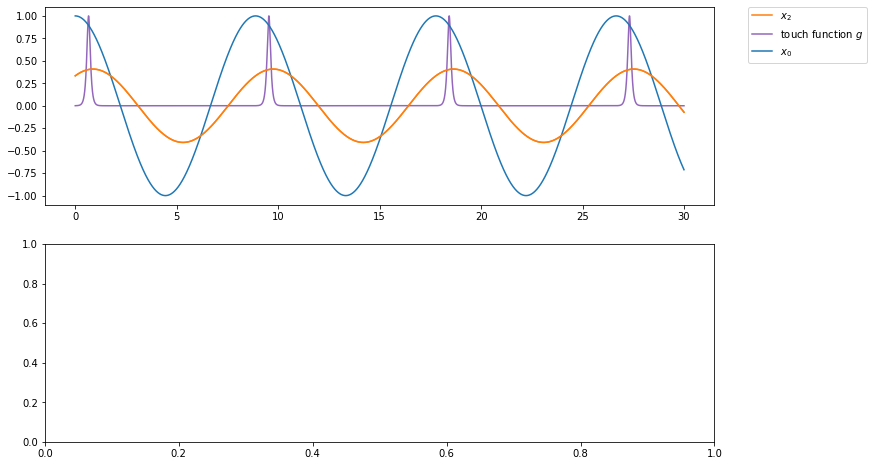

In [46]:
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plt.plot(time, x2, label=r"$x_2$", c='#ff7f0e')
    plt.plot(time, touch, label=r"touch function $g$", c='#9467bd')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.plot(time, x0, label=r"$x_0$", c='#1f77b4')
    #plt.plot(time, dtouch_dx0, label=r"$\frac{dg}{dx_0}$", c='#8c564b')
    # plt.plot(time, dtouch_dx2, label=r"$\frac{dg}{dx_2}$", c='#7f7f7f')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.plot(time, x2, label=r"$x_2$", c='#ff7f0e')
    plt.subplot(212)
    plt.plot(time, 2*dtouch_dx2, label=r"$\frac{dg}{dx_2}$", c='#7f7f7f')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    #plt.xlim([0,4])
    plt.show()